### One of the most important applications of optimization is vehicle routing, in which the goal is to find the best routes for a fleet of vehicles visiting a set of locations. Usually, "best" means routes with the least total distance or cost. Here are a few examples of routing problems:

+ **A package delivery company wants to assign routes for drivers to make deliveries**
+ **A cable TV company wants to assign routes for technicians to make residential service calls.**
+ **A ride-sharing company wants to assign routes for drivers to pick up and drop off passengers.**

### In the Vehicle Routing Problem (VRP), the goal is to find optimal routes for multiple vehicles visiting a set of locations. (When there's only one vehicle, it reduces to the Traveling Salesperson Problem.)

### But what do we mean by "optimal routes" for a VRP? One answer is the routes with the least total distance. However, if there are no other constraints, the optimal solution is to assign just one vehicle to visit all locations, and find the shortest route for that vehicle.

### In this case we have a VRP problem with capacity constraint. We can call this kind of problem with Capacitated Vehicle Routing Problem (CVRP).

### The Capacitated Vehicle Routing Problem (CVRP) is a VRP in which vehicles with limited carrying capacity need to pick up or deliver items at various locations. The items have a quantity, such as weight or volume, and the vehicles have a maximum capacity that they can carry. The problem is to pick up or deliver the items for the least cost, while never exceeding the capacity of the vehicles.

### Example of this problem (source: Google OR-Tools Documentation) :
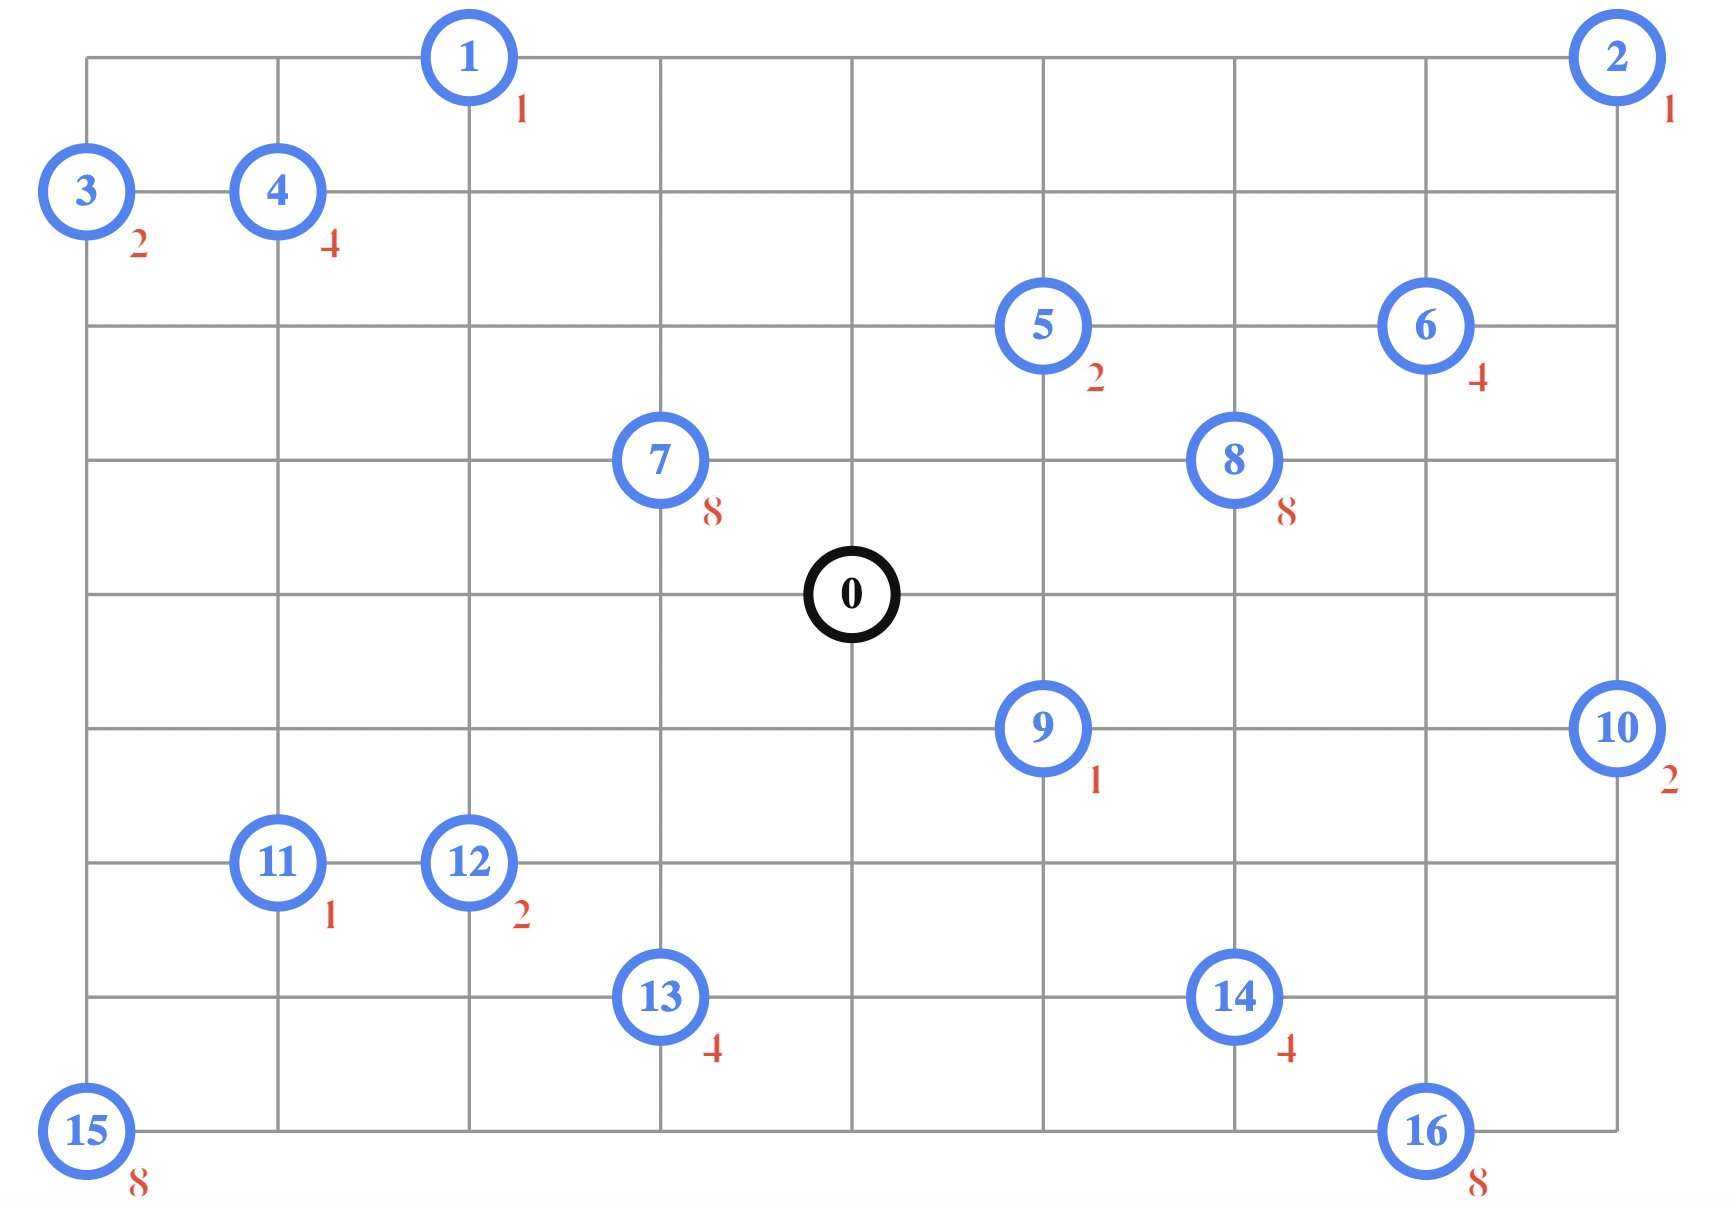

### Example of the solution (source: Google OR-Tools Documentation) :

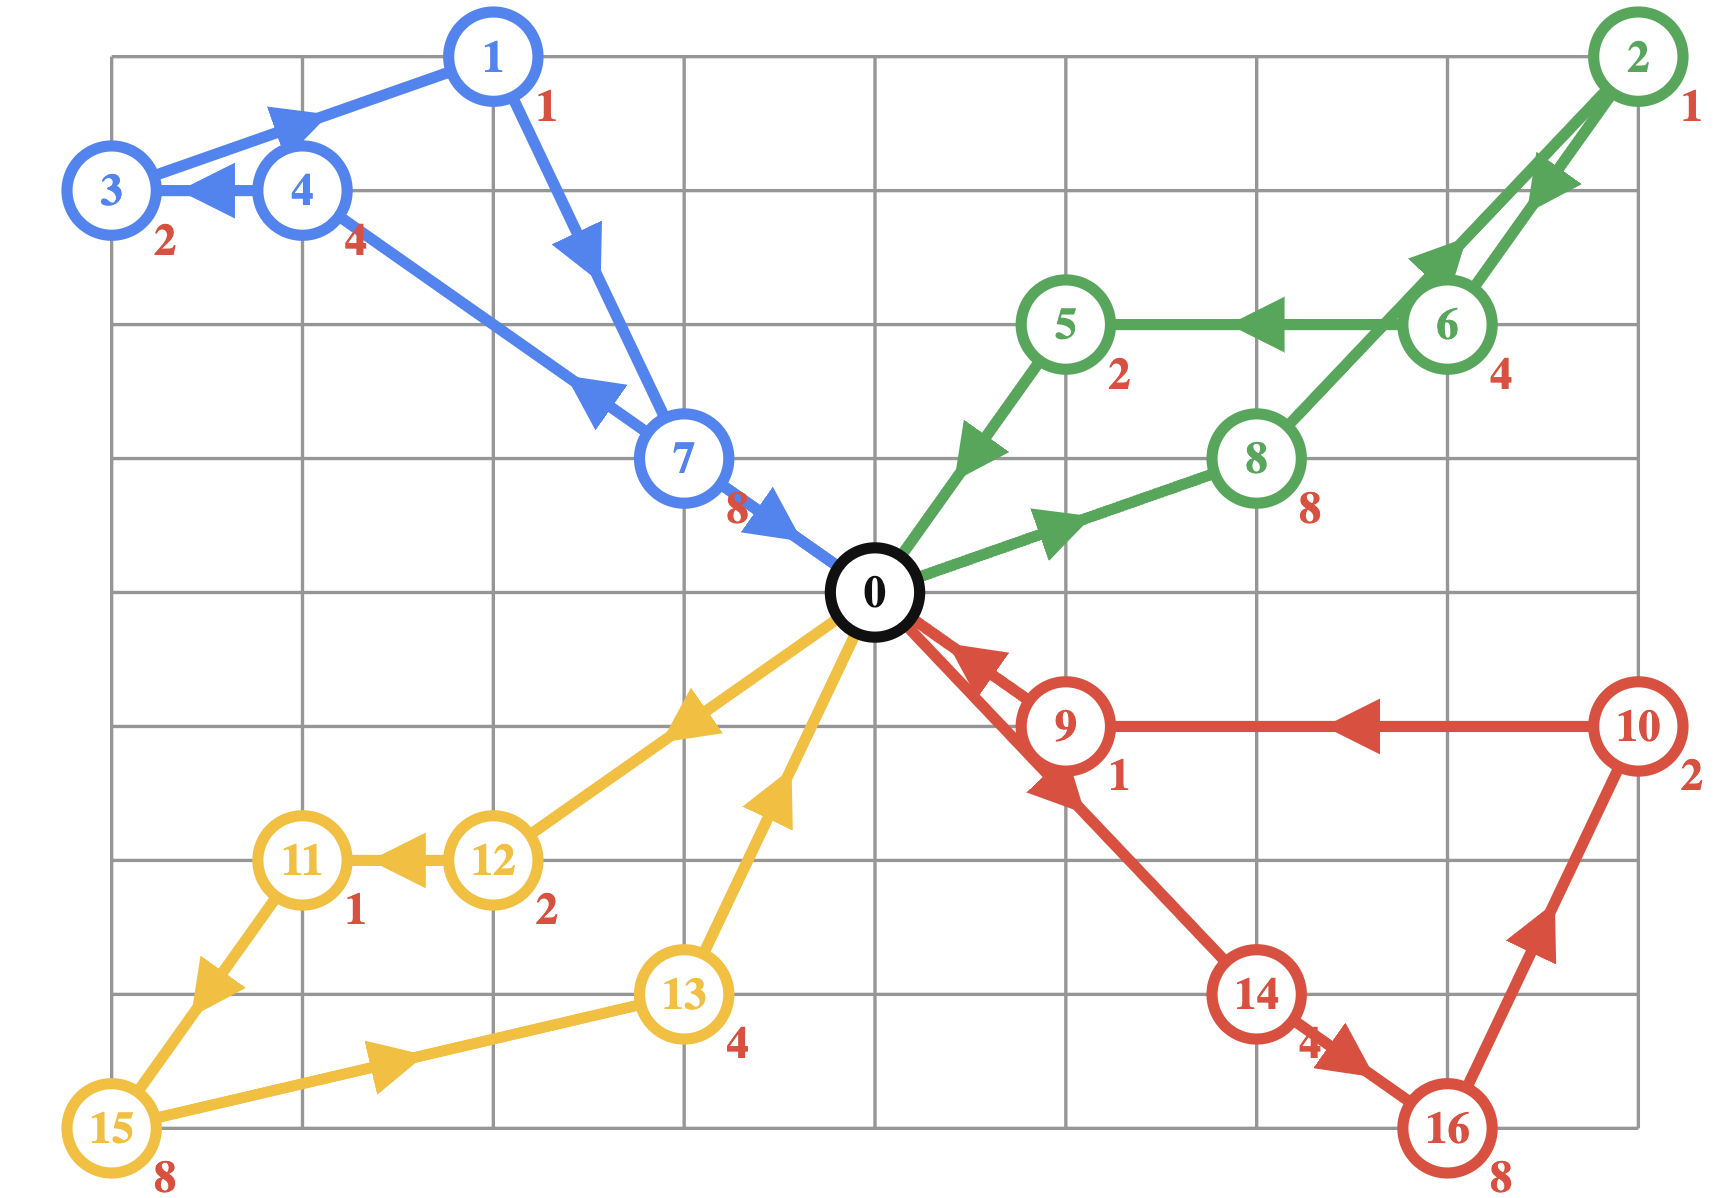

### In this problem i would like to optimize the routing of the courier or delivery vehicles trip from the depot to several drop points. This is the real problem where the data is obtained from Logistic or Shipping Company in Indonesia. I will use OR-Tools library from Google to help in making model and optimization.

# 1. Importing Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import requests
import polyline
import itertools
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import folium
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import xgboost

from IPython.display import display

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

sns.set(rc={'figure.figsize':(11.7,8.27)})

np.random.seed(1)

/Users/danielbeltsazar/opt/anaconda3/envs/boost/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/var/folders/52/_h12ds1j0_5c854m0gwwj0y80000gn/T/ipykernel_5893/3905498657.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

# 2. Importing Relevant Data

## 2.1. Import our middle mile logistics data

### This data contains all logistics data including origin and destination of the delivery.

### I will drop some confidental features because it is a real data from real logistic company

In [2]:
# middle mile data
df_mm = pd.read_csv('/Users/danielbeltsazar/Work/ZebraX/Resources/JX PoC (Vehicle Route Problem)/Code & preprocessing Data/Data/Middle Mile/df_mm.csv')

# change data type to time delta
col_delta = ['depart_time', 'arrival_time', 'lama_perjalanan']
for col in col_delta:
    df_mm[col] = pd.to_timedelta(df_mm[col])

# drop duplicate
df_mm = df_mm.drop_duplicates()

df_mm = df_mm.drop(['NOPOL','driver'],axis=1)

In [3]:
df_mm.head()

,driverlog_id,seal_code,origin_name,destination_name,depart_time,Depart Date,arrival_time,Arrival Date,state,lama_perjalanan,Ownership,INCLUDE DRIVER,Vehicle Type,Position,origin_latitude,origin_longitude,destination_latitude,destination_longitude,distance_per_liter
0,DDD7867-314,10208471C,DC MARUNDA,KARAWANG,0 days 01:58:00,2019-12-01,0 days 03:54:00,2019-12-01,tiba,0 days 01:55:55,JX,JX,CDE,DC Marunda,-6.094683,106.979533,-6.094683,106.979533,6
5,DDD7867-315,10208718C,DC MARUNDA,CIKARANG,0 days 02:27:00,2019-12-02,0 days 03:32:00,2019-12-02,tiba,0 days 01:05:27,JX,JX,CDE,DC Marunda,-6.094533,106.979110,-6.265340,107.074850,6
10,DDD8051-189,80208762C,DC MARUNDA,CIPUTAT,0 days 02:33:00,2019-12-03,0 days 04:26:00,2019-12-03,tiba,0 days 01:53:12,JX,JX,CDE,DC Marunda,-6.094454,106.979418,-6.094640,106.979710,6
15,DDD8051-190,10208868C,DC MARUNDA,BOGOR SEMPLAK,0 days 02:28:00,2019-12-04,0 days 04:19:00,2019-12-04,tiba,0 days 01:51:06,JX,JX,CDE,DC Marunda,-6.094457,106.979890,-6.094717,106.979468,6
20,DDD7867-316,10209798C,DC MARUNDA,KARAWANG,0 days 01:46:00,2019-12-05,0 days 03:34:00,2019-12-05,tiba,0 days 01:48:24,JX,JX,CDE,DC Marunda,-6.094508,106.979132,-6.094508,106.979132,6


## 2.2. Import shipment or delivery vehicle data

### This data contains information about our vehicle type and capacity

In [4]:
# middle mile vehicle 
df_mm_vehicle = pd.read_csv('/Users/danielbeltsazar/Work/ZebraX/Resources/JX PoC (Vehicle Route Problem)/Code & preprocessing Data/Data/Middle Mile/List Vehicle for Q2-Middle Mile.csv', sep=';')

# prepro NOPOL
#df_mm_vehicle['Plate Number'] = [i.replace(' ','') for i in df_mm_vehicle['Plate Number']]
#df_mm_vehicle = df_mm_vehicle.rename(columns={'Plate Number':'NOPOL'})

# create a dictionary of vehicle capacity
vehicle_capacity = {'GrandBox':5.5, 'CDE':3, 'CDD':5, 'LONG HINO':10, 'RANGER HINO':5.5, 'WINGBOX':7,
       'VAN':1}

# create vehicle_capacity columns base on the 'Vehicle Type columns'
df_mm_vehicle['vehicle_capacity'] = [vehicle_capacity[x] for x in df_mm_vehicle['Vehicle Type']]

df_mm_vehicle = df_mm_vehicle.drop(['Plate Number'],axis=1)

df_mm_vehicle.head()

,No,Ownership,INCLUDE DRIVER,Vehicle Type,Position,vehicle_capacity
0,1,JX,JX,GrandBox,DC Marunda,5.5
1,3,JX,JX,GrandBox,DC Marunda,5.5
2,5,JX,JX,CDE,DC Marunda,3.0
3,7,JX,JX,CDE,DC Marunda,3.0
4,8,JX,JX,CDE,DC Marunda,3.0


## 2.3. Import delivery weight data

### This data contains our pod_dp (drop points) name and weight of packages in every pod_dp

In [5]:
# weight dp data
df_mm_weight = pd.read_csv('/Users/danielbeltsazar/Work/ZebraX/Resources/JX PoC (Vehicle Route Problem)/Code & preprocessing Data/Data/Middle Mile/df_lm_weight.csv')
df_mm_weight

,delivered_date,pod_dp_name,weight
0,2019-12-01,BIG ITEM HUB,92.00
1,2019-12-01,CAKUNG,199.55
2,2019-12-01,CENGKARENG BARAT,4.00
3,2019-12-01,CIPAYUNG,1.00
4,2019-12-01,DUREN SAWIT,168.39
...,...,...,...
1348,2020-02-29,PENJARINGAN,3.00
1349,2020-02-29,PONDOK GEDE,8.50
1350,2020-02-29,PULO GADUNG,8.00
1351,2020-02-29,TANJUNG PRIOK,2.00


# 3. Relevant Functions

## 3.1. Function to get list of longitude and latitude of our depot and drop points locations

In [6]:
def folium_long_lat(df, cities):
    long_lat_list = []
    
    for city in cities:
        if city in df['origin_name'].values :
            lat = df.loc[df['origin_name'] == city, 'origin_latitude'].values[0]
            long = df.loc[df['origin_name'] == city, 'origin_longitude'].values[0]

        elif city in df['destination_name'].values:
            try:
                lat = df.loc[df['destination_name'] == city, 'destination_latitude'].values[2]
                long = df.loc[df['destination_name'] == city, 'destination_longitude'].values[2]
            except:
                lat = df.loc[df['destination_name'] == city, 'destination_latitude'].values[0]
                long = df.loc[df['destination_name'] == city, 'destination_longitude'].values[0]


        else :
            print('Error! city {} in DataFrame {} does not recognize!'.format(city, df))   

        city_long_lat = [long, lat]        

        long_lat_list.append(city_long_lat)
  
    return long_lat_list

## 3.2. Function to get distance matrix of every location of our depot and drop points.

In [7]:
# input ==> df, list of cities name in the DF return longitude and latitude list
def long_lat(df, cities):
    long_lat_list = []
    
    for i in range(len(cities)):
        city_long_lat =[]
        for city in cities[i]:
            if city in df['pod_dp_name'].values :
                lat = df.loc[df['pod_dp_name'] == city, 'pod_dp_latitude'].values[0]
                long = df.loc[df['pod_dp_name'] == city, 'pod_dp_longitude'].values[0]

            else :
                print('Error! city {} does not recognize!'.format(city))   
            
            city_long_lat.append(long)
            city_long_lat.append(lat)
        
        long_lat_list.append(city_long_lat)
  
    return long_lat_list

# using OSRM framework for getting distance matrix, input ==> longitude, latitude list
def get_distance(long_lat_list):
    count_failure = []
    distance_list = []
    for count,i in enumerate (range(len(long_lat_list))):
        print('process for : {} step'.format(count))
        pickup_lon, pickup_lat, dropoff_lon, dropoff_lat = long_lat_list[i]
#         print(pickup_lon, pickup_lat, dropoff_lon, dropoff_lat)

        loc = "{},{};{},{}".format(pickup_lon,pickup_lat,dropoff_lon,dropoff_lat)
        url = "http://router.project-osrm.org/route/v1/driving/"
        
        try:
            r = requests.get(url + loc) 
            res = r.json()
            distance = res['routes'][0]['distance']/1000
            
        except:
            count_failure.append(1)
            distance = np.nan
            pass
        
        distance_list.append(distance)
    
    print(len(count_failure))
    return distance_list


def main_distance_func(df, places):
    cities_list = []
        
    cities = list(itertools.product(places, places))
    print(places)
    long_lat_list = long_lat(df, cities)
    distance_list = [round(elem, 2) for elem in get_distance(long_lat_list)]
    
    # make matrix form
    n = len(places)
        
    distance_list = [distance_list[i:i + n] for i in range(0, len(distance_list), n)]
    
    return distance_list, places


# function for handeling nan result due to bad request
def redo(df, city1, city2):
    count_failure = []
    
    pickup_lat = df.loc[df['pod_dp_name'] == city1, 'pod_dp_latitude'].values[0]
    pickup_lon = df.loc[df['pod_dp_name'] == city1, 'pod_dp_longitude'].values[0]

    dropoff_lat = df.loc[df['pod_dp_name'] == city2, 'pod_dp_latitude'].values[0]
    dropoff_lon = df.loc[df['pod_dp_name'] == city2, 'pod_dp_longitude'].values[0]

    loc = "{},{};{},{}".format(pickup_lon,pickup_lat,dropoff_lon,dropoff_lat)
    url = "http://router.project-osrm.org/route/v1/driving/"
        
    try:
        r = requests.get(url + loc) 
        res = r.json()
        distance = res['routes'][0]['distance']/1000

    except:
        count_failure.append(1)
        distance = 'nan'
    
    print(len(count_failure))
    return distance

## 3.3. Function to make a route map using folium which is a geospatial library

In [8]:
def get_map(list_cities):
    """
    list of cities name as an input (ex: ['DC MARUNDA', 'SUBANG', 'KARAWANG'])
    """
    
    city = [dict_loc[x] for x in list_cities]
    n = len(city)
    loc_str = ('{},{};'*n)[:-1]
    
    # make 1d array of coordinate from list of city
    city_coor = [[x[0], x[1]] for x in city]
    cities = [j for sub in city_coor for j in sub]
    
    # get location and route
    loc = loc_str.format(*cities)
    url = "http://router.project-osrm.org/route/v1/driving/"
    r = requests.get(url + loc) 
    if r.status_code!= 200:
        print('request error')
        return {}
  
    res = r.json()   
    route = polyline.decode(res['routes'][0]['geometry'])
    
    # visualize route using folium
    m = folium.Map(location=[city[0][1], city[0][0]], zoom_start=10)
    
    folium.PolyLine(
        route,
        weight=8,
        color='blue',
        opacity=0.6
    ).add_to(m)
    
    for count, idx in enumerate(city[1:-1]):
        folium.Marker(popup=list_cities[count + 1],
            location=idx[::-1],
            icon=folium.Icon(color='green')
        ).add_to(m)
    
    folium.Marker(popup='DC Marunda',
        location=city[0][::-1],
        icon=folium.Icon(icon='stop', color='red')
    ).add_to(m)
    
    return m

# 4. MODELLING

## 4.1. Creating dictionary of our depot and drop points locations

In [9]:
list_places_distance = list(set(list(df_mm['origin_name'].unique()) + list(df_mm['destination_name'])))
len(list_places_distance), list_places_distance

(63,
 ['BOGOR CIOMAS',
  'PANCORAN',
  'KEMAYORAN',
  'SC TEGAL',
  'TANJUNG PRIOK',
  'CIPUTAT',
  'BOGOR SEMPLAK',
  'KUNINGAN',
  'KARAWACI',
  'KRAMAT JATI',
  'CIKARANG UTARA',
  'KEBAYORAN LAMA',
  'DC MARUNDA',
  'GAMBIR',
  'MAJALENGKA',
  'CIRACAS',
  'BEKASI TIMUR',
  'SUKMAJAYA',
  'TELUK NAGA',
  'SC BANDUNG',
  'DUREN SAWIT',
  'PONDOK GEDE',
  'KELAPA DUA',
  'KELAPA GADING',
  'PASAR KEMIS',
  'GROGOL PETAMBURAN',
  'KOTA BOGOR',
  'TIGARAKSA',
  'KAB. SERANG',
  'CILEDUG',
  'SAWANGAN',
  'DC SEMARANG',
  'CIMANGGIS',
  'CURUG',
  'PENJARINGAN',
  'KOTA BEKASI',
  'CIBINONG',
  'CIKARANG SELATAN',
  'KOTA TANGERANG',
  'CIANJUR',
  'INDRAMAYU',
  'CIKARANG',
  'PURWAKARTA',
  'SUKABUMI',
  'CIREBON',
  'JATINEGARA',
  'MAMPANG PRAPATAN',
  'LEUWISADENG',
  'KEMBANGAN',
  'SERPONG',
  'KEBON JERUK',
  'CILEGON',
  'CILINCING',
  'KOTA DEPOK',
  'CIKAMPEK',
  'CILEUNGSI',
  'KLARI',
  'PASAR MINGGU',
  'KOTA SERANG',
  'CENGKARENG BARAT',
  'PONDOK AREN',
  'SUBANG',
  'K

In [10]:
locationlist = folium_long_lat(df=df_mm, cities = list_places_distance)

# dict_loc = {places : coordinates}
dict_loc = dict(zip(list_places_distance,locationlist))

In [11]:
locationlist

[[106.88535, -6.310509],
 [106.96201, -6.107244000000001],
 [106.841108, -6.158258],
 [109.124734, -6.929537],
 [106.863404, -6.144421],
 [106.979538, -6.094918],
 [106.979558, -6.094557],
 [108.520747, -6.708469],
 [106.980193, -6.094618],
 [106.86543799999998, -6.286375],
 [107.181705, -6.277603],
 [106.979277, -6.094893],
 [106.979533, -6.094683],
 [106.8371, -6.164643],
 [108.255616, -6.738071000000001],
 [106.876807, -6.324233],
 [107.015505, -6.259365],
 [106.834589, -6.436934],
 [106.96248, -6.413606],
 [107.65135, -6.943805],
 [106.979175, -6.094628],
 [106.943062, -6.11017],
 [106.613225, -6.240508],
 [106.95008, -6.110197],
 [106.979452, -6.0944400000000005],
 [106.780294, -6.144280999999999],
 [106.979142, -6.094666999999999],
 [106.486518, -6.257008],
 [106.979035, -6.094462],
 [106.647247, -6.184777],
 [106.745779, -6.405901],
 [110.357441, -7.010205],
 [106.979075, -6.094353],
 [106.591993, -6.229342],
 [106.97929, -6.094836],
 [106.97163799999998, -6.248381],
 [106.85927

In [12]:
dict_loc

{'BOGOR CIOMAS': [106.88535, -6.310509],
 'PANCORAN': [106.96201, -6.107244000000001],
 'KEMAYORAN': [106.841108, -6.158258],
 'SC TEGAL': [109.124734, -6.929537],
 'TANJUNG PRIOK': [106.863404, -6.144421],
 'CIPUTAT': [106.979538, -6.094918],
 'BOGOR SEMPLAK': [106.979558, -6.094557],
 'KUNINGAN': [108.520747, -6.708469],
 'KARAWACI': [106.980193, -6.094618],
 'KRAMAT JATI': [106.86543799999998, -6.286375],
 'CIKARANG UTARA': [107.181705, -6.277603],
 'KEBAYORAN LAMA': [106.979277, -6.094893],
 'DC MARUNDA': [106.979533, -6.094683],
 'GAMBIR': [106.8371, -6.164643],
 'MAJALENGKA': [108.255616, -6.738071000000001],
 'CIRACAS': [106.876807, -6.324233],
 'BEKASI TIMUR': [107.015505, -6.259365],
 'SUKMAJAYA': [106.834589, -6.436934],
 'TELUK NAGA': [106.96248, -6.413606],
 'SC BANDUNG': [107.65135, -6.943805],
 'DUREN SAWIT': [106.979175, -6.094628],
 'PONDOK GEDE': [106.943062, -6.11017],
 'KELAPA DUA': [106.613225, -6.240508],
 'KELAPA GADING': [106.95008, -6.110197],
 'PASAR KEMIS': [1

In [13]:
df_sorted = df_mm.copy().drop_duplicates(subset='destination_name').reset_index(drop=True)
df_sorted

,driverlog_id,seal_code,origin_name,destination_name,depart_time,Depart Date,arrival_time,Arrival Date,state,lama_perjalanan,Ownership,INCLUDE DRIVER,Vehicle Type,Position,origin_latitude,origin_longitude,destination_latitude,destination_longitude,distance_per_liter
0,DDD7867-314,10208471C,DC MARUNDA,KARAWANG,0 days 01:58:00,2019-12-01,0 days 03:54:00,2019-12-01,tiba,0 days 01:55:55,JX,JX,CDE,DC Marunda,-6.094683,106.979533,-6.094683,106.979533,6
1,DDD7867-315,10208718C,DC MARUNDA,CIKARANG,0 days 02:27:00,2019-12-02,0 days 03:32:00,2019-12-02,tiba,0 days 01:05:27,JX,JX,CDE,DC Marunda,-6.094533,106.979110,-6.265340,107.074850,6
2,DDD8051-189,80208762C,DC MARUNDA,CIPUTAT,0 days 02:33:00,2019-12-03,0 days 04:26:00,2019-12-03,tiba,0 days 01:53:12,JX,JX,CDE,DC Marunda,-6.094454,106.979418,-6.094640,106.979710,6
3,DDD8051-190,10208868C,DC MARUNDA,BOGOR SEMPLAK,0 days 02:28:00,2019-12-04,0 days 04:19:00,2019-12-04,tiba,0 days 01:51:06,JX,JX,CDE,DC Marunda,-6.094457,106.979890,-6.094717,106.979468,6
4,DDD8051-191,10209807C,DC MARUNDA,LEUWISADENG,0 days 02:35:00,2019-12-05,0 days 04:50:00,2019-12-05,tiba,0 days 02:15:57,JX,JX,CDE,DC Marunda,-6.094378,106.979250,-6.094378,106.979250,6
5,DDD8051-192,10203725C,DC MARUNDA,KOTA BOGOR,0 days 02:28:00,2019-12-06,0 days 04:17:00,2019-12-06,tiba,0 days 01:49:04,JX,JX,CDE,DC Marunda,-6.094613,106.979102,-6.094613,106.979102,6
6,DDD8101-128,10221695C,DC MARUNDA,CIKAMPEK,0 days 03:25:00,2019-12-07,0 days 05:58:00,2019-12-07,tiba,0 days 02:33:07,JX,JX,CDE,DC Marunda,-6.094562,106.979543,-6.390194,107.416401,6
7,DDD8051-193,10221374C,DC MARUNDA,KEMBANGAN,0 days 12:02:00,2019-12-09,0 days 13:18:00,2019-12-09,tiba,0 days 01:15:34,JX,JX,CDE,DC Marunda,-6.093897,106.979310,-6.169708,106.775142,6
8,DDD8051-194,10221101C,DC MARUNDA,KARAWACI,0 days 12:11:00,2019-12-10,0 days 14:05:00,2019-12-10,tiba,0 days 01:53:46,JX,JX,CDE,DC Marunda,-6.094413,106.979048,-6.094413,106.979048,6
9,DDD7867-321,10221095C,DC MARUNDA,KOTA BEKASI,0 days 02:47:00,2019-12-11,0 days 03:53:00,2019-12-11,tiba,0 days 01:05:24,JX,JX,CDE,DC Marunda,-6.094643,106.979273,-6.094643,106.979273,6


## 4.2. Creating table of our depot and drop points locations

### Location from last mile data

In [14]:

df_loc = pd.read_csv('/Users/danielbeltsazar/Work/ZebraX/Resources/JX PoC (Vehicle Route Problem)/Code & preprocessing Data/Data/Middle Mile/df_lm_merge.csv')

df_loc.head()

,waybill_code,order_id,pre_sort_dp,province,city,district,create_time,pick_up_time,pick_up_dp_name,in_dc_time1,in_dc_name1,in_dc1_latitude,in_dc1_longitude,out_dc_time1,out_dc_name1,in_dp_time1,in_dp_name1,out_dp_time1,out_dp_name1,delivered_time,pod_dp_name,pod_dp_latitude,pod_dp_longitude,courier_name,create_date,pick_up_date,in_dc_date1,out_dc_date1,in_dp_date1,out_dp_date1,delivered_date,package_quantity,weight,location,loc_latitude,loc_longitude
0,PCGK181170363,245031017,GROGOL PETAMBURAN,Jakarta,Jakarta Barat,grogolpetamburan,2018-12-11,NaN,NaN,04:28:29,DC MARUNDA,-6.094465,106.97935,05:40:18,DC MARUNDA,NaN,NaN,10:07:40,GROGOL PETAMBURAN,19:27:15,GROGOL PETAMBURAN,-6.144411,106.780234,DodyP,2018-12-11,NaN,2018-12-12,2018-12-12,NaN,2018-12-21,2020-01-31,1,0.0,"KPP Pratama Grogol Petamburan, Jalan Letjen S....",-6.178288,106.796151
1,ACGK189158789,247484975,GROGOL PETAMBURAN,Jakarta,Jakarta Barat,grogolpetamburan,2018-12-20,NaN,NaN,07:36:38,DC MARUNDA,-6.094465,106.97935,10:15:37,DC MARUNDA,NaN,NaN,11:24:48,GROGOL PETAMBURAN,11:25:06,GROGOL PETAMBURAN,-6.144411,106.780234,AdamS,2018-12-20,NaN,2018-12-20,2018-12-20,NaN,2020-01-14,2020-01-14,1,1.0,"KPP Pratama Grogol Petamburan, Jalan Letjen S....",-6.178288,106.796151
2,JXFD01263689582,1011459395,GROGOL PETAMBURAN,Jakarta,Jakarta Barat,grogolpetamburan,2019-11-28,NaN,NaN,14:24:21,DC MARUNDA,-6.094465,106.97935,19:53:16,DC MARUNDA,06:31:08,GROGOL PETAMBURAN,NaN,NaN,17:45:28,GROGOL PETAMBURAN,-6.144411,106.780234,Rachmat,2019-11-28,NaN,2019-11-28,2019-11-28,2019-11-29,NaN,2019-12-02,1,0.0,"KPP Pratama Grogol Petamburan, Jalan Letjen S....",-6.178288,106.796151
3,JXPOP01259029995,1010827676,GROGOL PETAMBURAN,Jakarta,Jakarta Barat,grogolpetamburan,2019-11-18,10:13:06,JDGLOBAL,19:04:22,DC MARUNDA,-6.094465,106.97935,20:41:34,DC MARUNDA,06:31:12,GROGOL PETAMBURAN,07:57:13,GROGOL PETAMBURAN,11:01:44,GROGOL PETAMBURAN,-6.144411,106.780234,AdamS,2019-11-18,2019-11-20,2019-11-28,2019-11-28,2019-11-29,2019-11-29,2019-12-02,1,0.0,"KPP Pratama Grogol Petamburan, Jalan Letjen S....",-6.178288,106.796151
4,JXFD01263843840,1011477560,KEBON JERUK,Jakarta,Jakarta Barat,grogolpetamburan,2019-11-28,NaN,NaN,20:25:13,DC MARUNDA,-6.094465,106.97935,01:36:27,DC MARUNDA,06:31:06,GROGOL PETAMBURAN,NaN,NaN,10:11:38,KEBON JERUK,-6.171444,106.776167,HandyW,2019-11-28,NaN,2019-11-28,2019-11-29,2019-11-29,NaN,2019-12-02,1,0.0,"KPP Pratama Grogol Petamburan, Jalan Letjen S....",-6.178288,106.796151


In [15]:
df_loc = df_loc.drop(['waybill_code'],axis=1)

In [16]:
# get dp location from Last mile data
#df_loc = pd.read_csv('/Users/danielbeltsazar/Work/ZebraX/Resources/JX PoC (Vehicle Route Problem)/Code & preprocessing Data/Data/Middle Mile/df_lm_merge.csv')
df_loc = df_loc.drop_duplicates(subset='pod_dp_name').reset_index(drop=True)
df_loc = df_loc[['pod_dp_name', 'pod_dp_latitude', 'pod_dp_longitude']]

# get DC marunda name, latitude and longitude
dc_a, dc_b, dc_c = df_mm[['origin_name', 'origin_latitude', 'origin_longitude']].iloc[[0]].values[0]

# add DC marunda to dp dataframe
df_loc = df_loc.append({'pod_dp_name': dc_a, 'pod_dp_latitude':dc_b, 'pod_dp_longitude':dc_c}, ignore_index=True)
df_loc

,pod_dp_name,pod_dp_latitude,pod_dp_longitude
0,GROGOL PETAMBURAN,-6.144411,106.780234
1,KEBON JERUK,-6.171444,106.776167
2,BIG ITEM HUB,-6.094332,106.977742
3,CENGKARENG BARAT,-6.137370,106.740120
4,GAMBIR,-6.170693,106.808389
5,TANJUNG PRIOK,-6.144231,106.863135
6,PENJARINGAN,-6.120270,106.789960
7,KEMBANGAN,-6.171394,106.776340
8,PANCORAN,-6.253649,106.841436
9,MAMPANG PRAPATAN,-6.258275,106.823082


## 4.3. Creating Distance Matrix of our depot and drop points locations

In [17]:
# Intersection DP place from MM and LM data
places = list(set(df_loc['pod_dp_name']) & set(list_places_distance))
len(places)

24

In [18]:
places

['PANCORAN',
 'KEMAYORAN',
 'TANJUNG PRIOK',
 'GAMBIR',
 'KRAMAT JATI',
 'CIKARANG UTARA',
 'DC MARUNDA',
 'KEBAYORAN LAMA',
 'CIRACAS',
 'BEKASI TIMUR',
 'DUREN SAWIT',
 'PONDOK GEDE',
 'KELAPA GADING',
 'GROGOL PETAMBURAN',
 'PENJARINGAN',
 'KOTA BEKASI',
 'CIKARANG SELATAN',
 'CIKARANG',
 'JATINEGARA',
 'MAMPANG PRAPATAN',
 'KEMBANGAN',
 'KEBON JERUK',
 'PASAR MINGGU',
 'CENGKARENG BARAT']

In [19]:
#skip this functions
dis_matrix, places_matrix = main_distance_func(df_loc, places)
dis_matrix_tab = pd.DataFrame(dis_matrix, index=places_matrix, columns=places_matrix)

for col in dis_matrix_tab.columns:
    for idx in dis_matrix_tab.index:
        if np.isnan(dis_matrix_tab[col][idx]):
            print('converted!')
            resu = redo(df_loc, idx, col)
            dis_matrix_tab[col][idx] = resu   

            
dis_matrix_tab.isnull().sum()

['PANCORAN', 'KEMAYORAN', 'TANJUNG PRIOK', 'GAMBIR', 'KRAMAT JATI', 'CIKARANG UTARA', 'DC MARUNDA', 'KEBAYORAN LAMA', 'CIRACAS', 'BEKASI TIMUR', 'DUREN SAWIT', 'PONDOK GEDE', 'KELAPA GADING', 'GROGOL PETAMBURAN', 'PENJARINGAN', 'KOTA BEKASI', 'CIKARANG SELATAN', 'CIKARANG', 'JATINEGARA', 'MAMPANG PRAPATAN', 'KEMBANGAN', 'KEBON JERUK', 'PASAR MINGGU', 'CENGKARENG BARAT']
process for : 0 step
process for : 1 step
process for : 2 step
process for : 3 step
process for : 4 step
process for : 5 step
process for : 6 step
process for : 7 step
process for : 8 step
process for : 9 step
process for : 10 step
process for : 11 step
process for : 12 step
process for : 13 step
process for : 14 step
process for : 15 step
process for : 16 step
process for : 17 step
process for : 18 step
process for : 19 step
process for : 20 step
process for : 21 step
process for : 22 step
process for : 23 step
process for : 24 step
process for : 25 step
process for : 26 step
process for : 27 step
process for : 28 step

process for : 345 step
process for : 346 step
process for : 347 step
process for : 348 step
process for : 349 step
process for : 350 step
process for : 351 step
process for : 352 step
process for : 353 step
process for : 354 step
process for : 355 step
process for : 356 step
process for : 357 step
process for : 358 step
process for : 359 step
process for : 360 step
process for : 361 step
process for : 362 step
process for : 363 step
process for : 364 step
process for : 365 step
process for : 366 step
process for : 367 step
process for : 368 step
process for : 369 step
process for : 370 step
process for : 371 step
process for : 372 step
process for : 373 step
process for : 374 step
process for : 375 step
process for : 376 step
process for : 377 step
process for : 378 step
process for : 379 step
process for : 380 step
process for : 381 step
process for : 382 step
process for : 383 step
process for : 384 step
process for : 385 step
process for : 386 step
process for : 387 step
process for

PANCORAN             0
KEMAYORAN            0
TANJUNG PRIOK        0
GAMBIR               0
KRAMAT JATI          0
CIKARANG UTARA       0
DC MARUNDA           0
KEBAYORAN LAMA       0
CIRACAS              0
BEKASI TIMUR         0
DUREN SAWIT          0
PONDOK GEDE          0
KELAPA GADING        0
GROGOL PETAMBURAN    0
PENJARINGAN          0
KOTA BEKASI          0
CIKARANG SELATAN     0
CIKARANG             0
JATINEGARA           0
MAMPANG PRAPATAN     0
KEMBANGAN            0
KEBON JERUK          0
PASAR MINGGU         0
CENGKARENG BARAT     0
dtype: int64

In [20]:
# #skip this functions
dis_matrix_tab = dis_matrix_tab.round(2)
distance_matrix = dis_matrix_tab.to_numpy()
distance_matrix = distance_matrix.tolist()
distance_matrix

#dis_matrix_tab.to_csv('distance_matrix_table_MM_LM.csv', index = False)

[[0.0,
  14.09,
  20.81,
  12.47,
  6.89,
  44.28,
  32.23,
  9.64,
  13.37,
  22.61,
  9.67,
  15.62,
  18.32,
  16.51,
  18.14,
  16.54,
  42.23,
  29.45,
  8.87,
  2.45,
  13.86,
  13.68,
  5.05,
  24.83],
 [14.97,
  0.0,
  3.61,
  6.79,
  18.6,
  49.84,
  22.12,
  18.28,
  25.64,
  29.13,
  14.47,
  23.79,
  9.06,
  9.36,
  10.21,
  23.63,
  49.83,
  33.46,
  10.06,
  15.48,
  11.55,
  11.37,
  18.08,
  20.58],
 [16.58,
  4.54,
  0.0,
  9.56,
  20.52,
  49.12,
  19.34,
  21.06,
  26.41,
  28.41,
  15.46,
  24.56,
  6.19,
  14.11,
  11.76,
  21.86,
  48.06,
  32.73,
  11.67,
  18.4,
  14.33,
  14.15,
  21.0,
  21.58],
 [13.53,
  6.23,
  8.08,
  0.0,
  19.83,
  54.15,
  26.56,
  11.69,
  25.68,
  32.47,
  15.51,
  25.49,
  13.52,
  7.67,
  9.24,
  26.41,
  52.09,
  36.41,
  10.57,
  12.07,
  4.96,
  4.78,
  14.67,
  15.14],
 [7.6,
  18.98,
  22.25,
  21.05,
  0.0,
  45.78,
  33.67,
  18.23,
  7.59,
  24.1,
  11.11,
  9.56,
  19.76,
  25.09,
  26.72,
  17.98,
  43.72,
  30.94,
  11.29

In [21]:
dis_matrix_tab.to_csv('distance_matrix_table_MM_LM.csv', index = False)

In [22]:
distance_matrix = pd.read_csv('distance_matrix_table_MM_LM.csv')
distance_matrix

,PANCORAN,KEMAYORAN,TANJUNG PRIOK,GAMBIR,KRAMAT JATI,CIKARANG UTARA,DC MARUNDA,KEBAYORAN LAMA,CIRACAS,BEKASI TIMUR,DUREN SAWIT,PONDOK GEDE,KELAPA GADING,GROGOL PETAMBURAN,PENJARINGAN,KOTA BEKASI,CIKARANG SELATAN,CIKARANG,JATINEGARA,MAMPANG PRAPATAN,KEMBANGAN,KEBON JERUK,PASAR MINGGU,CENGKARENG BARAT
0,0.00,14.09,20.81,12.47,6.89,44.28,32.23,9.64,13.37,22.61,9.67,15.62,18.32,16.51,18.14,16.54,42.23,29.45,8.87,2.45,13.86,13.68,5.05,24.83
1,14.97,0.00,3.61,6.79,18.60,49.84,22.12,18.28,25.64,29.13,14.47,23.79,9.06,9.36,10.21,23.63,49.83,33.46,10.06,15.48,11.55,11.37,18.08,20.58
2,16.58,4.54,0.00,9.56,20.52,49.12,19.34,21.06,26.41,28.41,15.46,24.56,6.19,14.11,11.76,21.86,48.06,32.73,11.67,18.40,14.33,14.15,21.00,21.58
3,13.53,6.23,8.08,0.00,19.83,54.15,26.56,11.69,25.68,32.47,15.51,25.49,13.52,7.67,9.24,26.41,52.09,36.41,10.57,12.07,4.96,4.78,14.67,15.14
4,7.60,18.98,22.25,21.05,0.00,45.78,33.67,18.23,7.59,24.10,11.11,9.56,19.76,25.09,26.72,17.98,43.72,30.94,11.29,10.05,22.44,22.26,10.40,33.41
5,44.65,47.74,48.35,53.72,45.24,0.00,49.43,50.90,43.52,22.12,37.84,33.88,42.63,57.75,59.39,30.61,13.18,14.66,42.68,46.85,55.11,54.93,49.45,66.08
6,32.91,23.32,19.44,27.30,32.94,51.31,0.00,36.57,40.43,30.60,25.92,32.04,16.29,26.30,24.98,24.94,51.14,34.93,25.79,35.39,33.33,32.05,37.98,33.77
7,12.53,17.55,19.40,11.46,21.13,53.78,37.43,0.00,22.75,32.11,19.15,25.12,23.52,15.50,17.12,26.02,51.73,38.95,16.74,8.74,11.09,11.12,15.33,17.49
8,13.20,24.59,27.85,26.66,7.58,49.20,39.27,22.59,0.00,25.59,16.71,15.16,25.36,30.69,32.33,23.58,47.65,32.82,16.90,15.65,28.04,27.86,11.85,34.84
9,23.60,27.69,28.29,32.67,23.87,24.23,29.37,29.85,22.14,0.00,16.78,12.50,22.58,36.70,38.34,10.55,21.72,7.85,21.31,25.80,34.06,33.88,28.40,45.03


In [23]:
distance_matrix= distance_matrix.values.tolist()

In [24]:
distance_matrix

[[0.0,
  14.09,
  20.81,
  12.47,
  6.89,
  44.28,
  32.23,
  9.64,
  13.37,
  22.61,
  9.67,
  15.62,
  18.32,
  16.51,
  18.14,
  16.54,
  42.23,
  29.45,
  8.87,
  2.45,
  13.86,
  13.68,
  5.05,
  24.83],
 [14.97,
  0.0,
  3.61,
  6.79,
  18.6,
  49.84,
  22.12,
  18.28,
  25.64,
  29.13,
  14.47,
  23.79,
  9.06,
  9.36,
  10.21,
  23.63,
  49.83,
  33.46,
  10.06,
  15.48,
  11.55,
  11.37,
  18.08,
  20.58],
 [16.58,
  4.54,
  0.0,
  9.56,
  20.52,
  49.12,
  19.34,
  21.06,
  26.41,
  28.41,
  15.46,
  24.56,
  6.19,
  14.11,
  11.76,
  21.86,
  48.06,
  32.73,
  11.67,
  18.4,
  14.33,
  14.15,
  21.0,
  21.58],
 [13.53,
  6.23,
  8.08,
  0.0,
  19.83,
  54.15,
  26.56,
  11.69,
  25.68,
  32.47,
  15.51,
  25.49,
  13.52,
  7.67,
  9.24,
  26.41,
  52.09,
  36.41,
  10.57,
  12.07,
  4.96,
  4.78,
  14.67,
  15.14],
 [7.6,
  18.98,
  22.25,
  21.05,
  0.0,
  45.78,
  33.67,
  18.23,
  7.59,
  24.1,
  11.11,
  9.56,
  19.76,
  25.09,
  26.72,
  17.98,
  43.72,
  30.94,
  11.29

In [25]:
print('Tabel 1.1 Distance Matrix(distance between places in KM)')
print('can be obtained by entering the data org latitude, org longitude, des_ latitude, des_longitude from table 1.1 into OSRM tools')
distance_matrix_table = pd.DataFrame(distance_matrix, index=places, columns=places)
distance_matrix_table

Tabel 1.1 Distance Matrix(distance between places in KM)
can be obtained by entering the data org latitude, org longitude, des_ latitude, des_longitude from table 1.1 into OSRM tools


,PANCORAN,KEMAYORAN,TANJUNG PRIOK,GAMBIR,KRAMAT JATI,CIKARANG UTARA,DC MARUNDA,KEBAYORAN LAMA,CIRACAS,BEKASI TIMUR,DUREN SAWIT,PONDOK GEDE,KELAPA GADING,GROGOL PETAMBURAN,PENJARINGAN,KOTA BEKASI,CIKARANG SELATAN,CIKARANG,JATINEGARA,MAMPANG PRAPATAN,KEMBANGAN,KEBON JERUK,PASAR MINGGU,CENGKARENG BARAT
PANCORAN,0.00,14.09,20.81,12.47,6.89,44.28,32.23,9.64,13.37,22.61,9.67,15.62,18.32,16.51,18.14,16.54,42.23,29.45,8.87,2.45,13.86,13.68,5.05,24.83
KEMAYORAN,14.97,0.00,3.61,6.79,18.60,49.84,22.12,18.28,25.64,29.13,14.47,23.79,9.06,9.36,10.21,23.63,49.83,33.46,10.06,15.48,11.55,11.37,18.08,20.58
TANJUNG PRIOK,16.58,4.54,0.00,9.56,20.52,49.12,19.34,21.06,26.41,28.41,15.46,24.56,6.19,14.11,11.76,21.86,48.06,32.73,11.67,18.40,14.33,14.15,21.00,21.58
GAMBIR,13.53,6.23,8.08,0.00,19.83,54.15,26.56,11.69,25.68,32.47,15.51,25.49,13.52,7.67,9.24,26.41,52.09,36.41,10.57,12.07,4.96,4.78,14.67,15.14
KRAMAT JATI,7.60,18.98,22.25,21.05,0.00,45.78,33.67,18.23,7.59,24.10,11.11,9.56,19.76,25.09,26.72,17.98,43.72,30.94,11.29,10.05,22.44,22.26,10.40,33.41
CIKARANG UTARA,44.65,47.74,48.35,53.72,45.24,0.00,49.43,50.90,43.52,22.12,37.84,33.88,42.63,57.75,59.39,30.61,13.18,14.66,42.68,46.85,55.11,54.93,49.45,66.08
DC MARUNDA,32.91,23.32,19.44,27.30,32.94,51.31,0.00,36.57,40.43,30.60,25.92,32.04,16.29,26.30,24.98,24.94,51.14,34.93,25.79,35.39,33.33,32.05,37.98,33.77
KEBAYORAN LAMA,12.53,17.55,19.40,11.46,21.13,53.78,37.43,0.00,22.75,32.11,19.15,25.12,23.52,15.50,17.12,26.02,51.73,38.95,16.74,8.74,11.09,11.12,15.33,17.49
CIRACAS,13.20,24.59,27.85,26.66,7.58,49.20,39.27,22.59,0.00,25.59,16.71,15.16,25.36,30.69,32.33,23.58,47.65,32.82,16.90,15.65,28.04,27.86,11.85,34.84
BEKASI TIMUR,23.60,27.69,28.29,32.67,23.87,24.23,29.37,29.85,22.14,0.00,16.78,12.50,22.58,36.70,38.34,10.55,21.72,7.85,21.31,25.80,34.06,33.88,28.40,45.03


## 4.4. Creating table that contains our weight constraints of every locations

In [26]:
df_mm_weight.sort_values(by='weight', ascending=False).reset_index(drop=True)

,delivered_date,pod_dp_name,weight
0,2019-12-10,GROGOL PETAMBURAN,1296.41
1,2019-12-13,GROGOL PETAMBURAN,1119.86
2,2019-12-14,GROGOL PETAMBURAN,1096.06
3,2020-02-26,GROGOL PETAMBURAN,1032.73
4,2019-12-16,GAMBIR,992.58
...,...,...,...
1348,2019-12-04,KRAMAT JATI,0.05
1349,2019-12-03,KEMAYORAN,0.05
1350,2019-12-03,CENGKARENG BARAT,0.04
1351,2019-12-11,KEMAYORAN,0.04


In [27]:
df_mm_weight_mean = df_mm_weight.groupby(['pod_dp_name'])['weight'].mean().reset_index()
df_mm_weight_mean['weight'] = df_mm_weight_mean['weight'].round(decimals=1)
df_mm_weight_mean['weight'] = [1.0 if x < 1 else x for x in df_mm_weight_mean['weight']] # change weight to 1 if weight is < 1
df_mm_weight_mean = df_mm_weight_mean.append({'pod_dp_name':'DC MARUNDA', 'weight': 0.0}, ignore_index=True) # add DC MARUNDA to df with weight 0
df_mm_weight_mean['weight'] = df_mm_weight_mean['weight'].astype(int)
df_mm_weight_mean.sort_values(by='weight', ascending=False).reset_index(drop=True)


,pod_dp_name,weight
0,GROGOL PETAMBURAN,517
1,GAMBIR,413
2,CAKUNG,267
3,DUREN SAWIT,220
4,MAMPANG PRAPATAN,185
5,KEBON JERUK,168
6,PASAR MINGGU,159
7,JATINEGARA,134
8,KEBAYORAN LAMA,98
9,BIG ITEM HUB,86


In [28]:
df_mm_vehicle

,No,Ownership,INCLUDE DRIVER,Vehicle Type,Position,vehicle_capacity
0,1,JX,JX,GrandBox,DC Marunda,5.5
1,3,JX,JX,GrandBox,DC Marunda,5.5
2,5,JX,JX,CDE,DC Marunda,3.0
3,7,JX,JX,CDE,DC Marunda,3.0
4,8,JX,JX,CDE,DC Marunda,3.0
5,10,JX,JX,CDE,DC Marunda,3.0
6,12,JX,JX,CDE,DC Marunda,3.0
7,13,JX,JX,CDE,DC Marunda,3.0
8,14,JX,JX,CDE,DC Marunda,3.0
9,16,JX,JX,CDE,DC Marunda,3.0


In [29]:
# create new distance matrix
places_capacity = list(set(df_mm_weight_mean['pod_dp_name']) & set(places))
places_noncapacity = list(set(distance_matrix_table.columns) - set(places_capacity))

In [30]:
places_capacity

['PANCORAN',
 'KEMAYORAN',
 'TANJUNG PRIOK',
 'GAMBIR',
 'KRAMAT JATI',
 'CIKARANG UTARA',
 'DC MARUNDA',
 'KEBAYORAN LAMA',
 'CIRACAS',
 'BEKASI TIMUR',
 'DUREN SAWIT',
 'PONDOK GEDE',
 'KELAPA GADING',
 'GROGOL PETAMBURAN',
 'PENJARINGAN',
 'KOTA BEKASI',
 'CIKARANG SELATAN',
 'CIKARANG',
 'JATINEGARA',
 'MAMPANG PRAPATAN',
 'KEMBANGAN',
 'KEBON JERUK',
 'PASAR MINGGU',
 'CENGKARENG BARAT']

In [31]:
places_noncapacity

[]

In [32]:
# create new distance matrix
#places_capacity = list(set(df_mm_weight_mean['pod_dp_name']) & set(places))
#places_noncapacity = list(set(distance_matrix_table.columns) - set(places_capacity))

# drop some places
distance_matrix_capacity = distance_matrix_table.drop(places_noncapacity, axis='index')
distance_matrix_capacity = distance_matrix_capacity.drop(columns=places_noncapacity)

# re-identify
distance_capacity = distance_matrix_capacity.values.tolist()
places_capacity = list(distance_matrix_capacity.columns)

distance_matrix_capacity.shape

(24, 24)

In [33]:
distance_matrix_capacity

,PANCORAN,KEMAYORAN,TANJUNG PRIOK,GAMBIR,KRAMAT JATI,CIKARANG UTARA,DC MARUNDA,KEBAYORAN LAMA,CIRACAS,BEKASI TIMUR,DUREN SAWIT,PONDOK GEDE,KELAPA GADING,GROGOL PETAMBURAN,PENJARINGAN,KOTA BEKASI,CIKARANG SELATAN,CIKARANG,JATINEGARA,MAMPANG PRAPATAN,KEMBANGAN,KEBON JERUK,PASAR MINGGU,CENGKARENG BARAT
PANCORAN,0.00,14.09,20.81,12.47,6.89,44.28,32.23,9.64,13.37,22.61,9.67,15.62,18.32,16.51,18.14,16.54,42.23,29.45,8.87,2.45,13.86,13.68,5.05,24.83
KEMAYORAN,14.97,0.00,3.61,6.79,18.60,49.84,22.12,18.28,25.64,29.13,14.47,23.79,9.06,9.36,10.21,23.63,49.83,33.46,10.06,15.48,11.55,11.37,18.08,20.58
TANJUNG PRIOK,16.58,4.54,0.00,9.56,20.52,49.12,19.34,21.06,26.41,28.41,15.46,24.56,6.19,14.11,11.76,21.86,48.06,32.73,11.67,18.40,14.33,14.15,21.00,21.58
GAMBIR,13.53,6.23,8.08,0.00,19.83,54.15,26.56,11.69,25.68,32.47,15.51,25.49,13.52,7.67,9.24,26.41,52.09,36.41,10.57,12.07,4.96,4.78,14.67,15.14
KRAMAT JATI,7.60,18.98,22.25,21.05,0.00,45.78,33.67,18.23,7.59,24.10,11.11,9.56,19.76,25.09,26.72,17.98,43.72,30.94,11.29,10.05,22.44,22.26,10.40,33.41
CIKARANG UTARA,44.65,47.74,48.35,53.72,45.24,0.00,49.43,50.90,43.52,22.12,37.84,33.88,42.63,57.75,59.39,30.61,13.18,14.66,42.68,46.85,55.11,54.93,49.45,66.08
DC MARUNDA,32.91,23.32,19.44,27.30,32.94,51.31,0.00,36.57,40.43,30.60,25.92,32.04,16.29,26.30,24.98,24.94,51.14,34.93,25.79,35.39,33.33,32.05,37.98,33.77
KEBAYORAN LAMA,12.53,17.55,19.40,11.46,21.13,53.78,37.43,0.00,22.75,32.11,19.15,25.12,23.52,15.50,17.12,26.02,51.73,38.95,16.74,8.74,11.09,11.12,15.33,17.49
CIRACAS,13.20,24.59,27.85,26.66,7.58,49.20,39.27,22.59,0.00,25.59,16.71,15.16,25.36,30.69,32.33,23.58,47.65,32.82,16.90,15.65,28.04,27.86,11.85,34.84
BEKASI TIMUR,23.60,27.69,28.29,32.67,23.87,24.23,29.37,29.85,22.14,0.00,16.78,12.50,22.58,36.70,38.34,10.55,21.72,7.85,21.31,25.80,34.06,33.88,28.40,45.03


In [34]:
distance_capacity

[[0.0,
  14.09,
  20.81,
  12.47,
  6.89,
  44.28,
  32.23,
  9.64,
  13.37,
  22.61,
  9.67,
  15.62,
  18.32,
  16.51,
  18.14,
  16.54,
  42.23,
  29.45,
  8.87,
  2.45,
  13.86,
  13.68,
  5.05,
  24.83],
 [14.97,
  0.0,
  3.61,
  6.79,
  18.6,
  49.84,
  22.12,
  18.28,
  25.64,
  29.13,
  14.47,
  23.79,
  9.06,
  9.36,
  10.21,
  23.63,
  49.83,
  33.46,
  10.06,
  15.48,
  11.55,
  11.37,
  18.08,
  20.58],
 [16.58,
  4.54,
  0.0,
  9.56,
  20.52,
  49.12,
  19.34,
  21.06,
  26.41,
  28.41,
  15.46,
  24.56,
  6.19,
  14.11,
  11.76,
  21.86,
  48.06,
  32.73,
  11.67,
  18.4,
  14.33,
  14.15,
  21.0,
  21.58],
 [13.53,
  6.23,
  8.08,
  0.0,
  19.83,
  54.15,
  26.56,
  11.69,
  25.68,
  32.47,
  15.51,
  25.49,
  13.52,
  7.67,
  9.24,
  26.41,
  52.09,
  36.41,
  10.57,
  12.07,
  4.96,
  4.78,
  14.67,
  15.14],
 [7.6,
  18.98,
  22.25,
  21.05,
  0.0,
  45.78,
  33.67,
  18.23,
  7.59,
  24.1,
  11.11,
  9.56,
  19.76,
  25.09,
  26.72,
  17.98,
  43.72,
  30.94,
  11.29

In [35]:
distance_matrix_capacity.columns

Index(['PANCORAN', 'KEMAYORAN', 'TANJUNG PRIOK', 'GAMBIR', 'KRAMAT JATI', 'CIKARANG UTARA', 'DC MARUNDA', 'KEBAYORAN LAMA', 'CIRACAS', 'BEKASI TIMUR', 'DUREN SAWIT', 'PONDOK GEDE', 'KELAPA GADING', 'GROGOL PETAMBURAN', 'PENJARINGAN', 'KOTA BEKASI', 'CIKARANG SELATAN', 'CIKARANG', 'JATINEGARA', 'MAMPANG PRAPATAN', 'KEMBANGAN', 'KEBON JERUK', 'PASAR MINGGU', 'CENGKARENG BARAT'], dtype='object')

In [36]:
vehicle_capacity

{'GrandBox': 5.5,
 'CDE': 3,
 'CDD': 5,
 'LONG HINO': 10,
 'RANGER HINO': 5.5,
 'WINGBOX': 7,
 'VAN': 1}

In [37]:
# create demand list
demand_list = df_mm_weight_mean[df_mm_weight_mean['pod_dp_name'].isin(places_capacity)].reset_index(drop=True) # filter only pod_dp in list places
demand_list = demand_list.set_index('pod_dp_name') # change pod_dp as index 
demand_list = demand_list.loc[distance_matrix_capacity.columns] # sort based on the distance_matrix_capacity order
demand_list = list(demand_list['weight'].values) # get only weight value

demand_list


[4,
 2,
 3,
 413,
 2,
 1,
 0,
 98,
 2,
 1,
 220,
 2,
 3,
 517,
 2,
 1,
 1,
 2,
 134,
 185,
 1,
 168,
 159,
 3]

In [38]:
# vehicle capacity
vehicle_capacity_list = [x for x in (list(vehicle_capacity.values()))]
vehicle_capacity_list = [int(x*1000) for x in vehicle_capacity_list]*4

In [39]:
vehicle_capacity_list

[5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000,
 5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000,
 5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000,
 5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000]

In [40]:
#INPUT : 
#    1. 

In [41]:
def create_data_model():
    """Stores the data for the problem."""
    data = {}
    data['distance_matrix'] = distance_capacity
    data['demands'] = demand_list
    data['vehicle_capacities'] = vehicle_capacity_list
    data['num_vehicles'] = len(vehicle_capacity_list)
    data['depot'] = distance_matrix_capacity.columns.get_loc('DC MARUNDA')
    return data

In [42]:
distance_capacity

[[0.0,
  14.09,
  20.81,
  12.47,
  6.89,
  44.28,
  32.23,
  9.64,
  13.37,
  22.61,
  9.67,
  15.62,
  18.32,
  16.51,
  18.14,
  16.54,
  42.23,
  29.45,
  8.87,
  2.45,
  13.86,
  13.68,
  5.05,
  24.83],
 [14.97,
  0.0,
  3.61,
  6.79,
  18.6,
  49.84,
  22.12,
  18.28,
  25.64,
  29.13,
  14.47,
  23.79,
  9.06,
  9.36,
  10.21,
  23.63,
  49.83,
  33.46,
  10.06,
  15.48,
  11.55,
  11.37,
  18.08,
  20.58],
 [16.58,
  4.54,
  0.0,
  9.56,
  20.52,
  49.12,
  19.34,
  21.06,
  26.41,
  28.41,
  15.46,
  24.56,
  6.19,
  14.11,
  11.76,
  21.86,
  48.06,
  32.73,
  11.67,
  18.4,
  14.33,
  14.15,
  21.0,
  21.58],
 [13.53,
  6.23,
  8.08,
  0.0,
  19.83,
  54.15,
  26.56,
  11.69,
  25.68,
  32.47,
  15.51,
  25.49,
  13.52,
  7.67,
  9.24,
  26.41,
  52.09,
  36.41,
  10.57,
  12.07,
  4.96,
  4.78,
  14.67,
  15.14],
 [7.6,
  18.98,
  22.25,
  21.05,
  0.0,
  45.78,
  33.67,
  18.23,
  7.59,
  24.1,
  11.11,
  9.56,
  19.76,
  25.09,
  26.72,
  17.98,
  43.72,
  30.94,
  11.29

In [43]:
demand_list

[4,
 2,
 3,
 413,
 2,
 1,
 0,
 98,
 2,
 1,
 220,
 2,
 3,
 517,
 2,
 1,
 1,
 2,
 134,
 185,
 1,
 168,
 159,
 3]

In [44]:
len(demand_list)

24

In [45]:
vehicle_capacity_list

[5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000,
 5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000,
 5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000,
 5500,
 3000,
 5000,
 10000,
 5500,
 7000,
 1000]

In [46]:
len(vehicle_capacity_list)

28

In [47]:
distance_matrix_capacity.columns.get_loc('DC MARUNDA')

6

In [48]:
def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    total_distance = 0
    total_load = 0

    list_vehicle1 = [] # add
    list_distance1 = [] # add
    list_place1 = [] # add
    list_load1 = [] # add
    
    for vehicle_id in range(data['num_vehicles']):
        abc = [] # add
        
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        route_load = 0
        sum_route_load = 0
        
        while not routing.IsEnd(index):
            
            node_index = manager.IndexToNode(index)
            route_load = data['demands'][node_index]
            sum_route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(places_capacity[int(manager.IndexToNode(index))], route_load)
            
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
            

            abc.append(places_capacity[int(manager.IndexToNode(index))]) # add
        
        if route_load != 0 :
            plan_output += ' {0} Load({1})\n'.format(places_capacity[int(manager.IndexToNode(index))],
                                                     0)
            abc.append(places_capacity[int(manager.IndexToNode(index))])
            
            if route_distance == 0:
                route_distance = 40
                
            plan_output += 'Distance of the route: {} KM\n'.format(route_distance)
            plan_output += 'Load of the route: {}\n'.format(sum_route_load)
        else:
            continue
        
            
        print(plan_output)
        
        total_distance += route_distance
        total_load += sum_route_load
        
        list_place1.append(abc)
        
    
    print('Total distance of all routes: {} KM'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    
    return list_place1

In [49]:
def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model()

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)


    # Add Capacity constraint.    
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(
        demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')
    
    # Add Distance Constraint.
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack 
        150,  # vehicle maximum  travel time 
        True,  # start cumul to zero
        'Distance')

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
#     search_parameters.time_limit.seconds = 40
    search_parameters.solution_limit = 200
    search_parameters.log_search = True


    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        list_places = print_solution(data, manager, routing, solution)
    
    else:
        list_places = 'No solution'
        
    return list_places

if __name__ == '__main__':
    list_places_load = main()
    for a in list_places_load:
        a.insert(0, a.pop())

Route for vehicle 25:
 DC MARUNDA Load(0) ->  KOTA BEKASI Load(1) ->  BEKASI TIMUR Load(1) ->  CIKARANG SELATAN Load(1) ->  CIKARANG UTARA Load(1) ->  CIKARANG Load(2) ->  PONDOK GEDE Load(2) ->  DUREN SAWIT Load(220) ->  DC MARUNDA Load(0)
Distance of the route: 133 KM
Load of the route: 228

Route for vehicle 26:
 DC MARUNDA Load(0) ->  PENJARINGAN Load(2) ->  GROGOL PETAMBURAN Load(517) ->  CENGKARENG BARAT Load(3) ->  KEBON JERUK Load(168) ->  KEMBANGAN Load(1) ->  GAMBIR Load(413) ->  KEBAYORAN LAMA Load(98) ->  MAMPANG PRAPATAN Load(185) ->  PASAR MINGGU Load(159) ->  CIRACAS Load(2) ->  KRAMAT JATI Load(2) ->  PANCORAN Load(4) ->  JATINEGARA Load(134) ->  KEMAYORAN Load(2) ->  TANJUNG PRIOK Load(3) ->  KELAPA GADING Load(3) ->  DC MARUNDA Load(0)
Distance of the route: 141 KM
Load of the route: 1696

Total distance of all routes: 274 KM
Total load of all routes: 1924


I0312 20:47:07.582997     1 search.cc:264] Start search (memory used = 103.16 MB)
I0312 20:47:07.583521     1 search.cc:264] Root node processed (time = 0 ms, constraints = 610, memory used = 103.36 MB)
I0312 20:47:07.585218     1 search.cc:264] Solution #0 (402, time = 2 ms, branches = 34, failures = 1, depth = 33, memory used = 103.63 MB, limit = 0%)
I0312 20:47:07.586003     1 search.cc:264] Solution #1 (389, objective maximum = 402, time = 2 ms, branches = 38, failures = 3, depth = 33, Relocate<1>, neighbors = 112, filtered neighbors = 1, accepted neighbors = 1, memory used = 103.72 MB, limit = 1%)
I0312 20:47:07.586214     1 search.cc:264] Solution #2 (387, objective maximum = 402, time = 3 ms, branches = 43, failures = 5, depth = 33, Relocate<1>, neighbors = 113, filtered neighbors = 2, accepted neighbors = 2, memory used = 103.73 MB, limit = 1%)
I0312 20:47:07.586418     1 search.cc:264] Solution #3 (386, objective maximum = 402, time = 3 ms, branches = 47, failures = 7, depth =

In [50]:
list_places_load

[['DC MARUNDA',
  'KOTA BEKASI',
  'BEKASI TIMUR',
  'CIKARANG SELATAN',
  'CIKARANG UTARA',
  'CIKARANG',
  'PONDOK GEDE',
  'DUREN SAWIT',
  'DC MARUNDA'],
 ['DC MARUNDA',
  'PENJARINGAN',
  'GROGOL PETAMBURAN',
  'CENGKARENG BARAT',
  'KEBON JERUK',
  'KEMBANGAN',
  'GAMBIR',
  'KEBAYORAN LAMA',
  'MAMPANG PRAPATAN',
  'PASAR MINGGU',
  'CIRACAS',
  'KRAMAT JATI',
  'PANCORAN',
  'JATINEGARA',
  'KEMAYORAN',
  'TANJUNG PRIOK',
  'KELAPA GADING',
  'DC MARUNDA']]

In [51]:
key_loc = df_loc['pod_dp_name']
value_loc = list(zip(df_loc['pod_dp_longitude'], df_loc['pod_dp_latitude']))

value_loc = [list(item) for item in value_loc]

for idx in range(len(value_loc)):
    value_loc[idx] = list(np.round(value_loc[idx], 4))

dict_loc = dict(zip(key_loc, value_loc))
dict_loc

{'GROGOL PETAMBURAN': [106.7802, -6.1444],
 'KEBON JERUK': [106.7762, -6.1714],
 'BIG ITEM HUB': [106.9777, -6.0943],
 'CENGKARENG BARAT': [106.7401, -6.1374],
 'GAMBIR': [106.8084, -6.1707],
 'TANJUNG PRIOK': [106.8631, -6.1442],
 'PENJARINGAN': [106.79, -6.1203],
 'KEMBANGAN': [106.7763, -6.1714],
 'PANCORAN': [106.8414, -6.2536],
 'MAMPANG PRAPATAN': [106.8231, -6.2583],
 'BEKASI TIMUR': [107.0154, -6.2594],
 'KEBAYORAN LAMA': [106.7711, -6.2381],
 'CIKARANG UTARA': [107.1817, -6.2777],
 'KELAPA GADING': [106.8981, -6.1465],
 'KEMAYORAN': [106.8409, -6.1582],
 'PASAR MINGGU': [106.8331, -6.2792],
 'CAKUNG': [106.9359, -6.1985],
 'cilincing': [106.9389, -6.1051],
 'CIPAYUNG': [106.8768, -6.3243],
 'DUREN SAWIT': [106.8981, -6.2328],
 'KOTA BEKASI': [106.9718, -6.2484],
 'JATINEGARA': [106.8661, -6.2192],
 'PULO GADUNG': [106.8661, -6.2192],
 'CIKARANG': [107.075, -6.2655],
 'CIRACAS': [106.8768, -6.3243],
 'KRAMAT JATI': [106.8655, -6.2863],
 'PONDOK GEDE': [106.9367, -6.2862],
 'CIK

In [52]:
get_map(list_places_load[0])

In [53]:
get_map(list_places_load[1])

In [54]:
a = df_mm[df_mm['Depart Date'] == '2019-12-01']
a['NOPOL'].nunique(), a.shape[0]

KeyError: 'NOPOL'

In [ ]:
df_mm.groupby(['Depart Date', 'NOPOL'])['NOPOL'].count()

In [ ]:
df_mm.groupby(['Depart Date'])['NOPOL'].count().reset_index()

In [ ]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

current_dp = df_mm[['Depart Date', 'NOPOL']].sort_values(['Depart Date']).reset_index(drop=True)
c = df_mm.groupby((['Depart Date', 'NOPOL'])).size().reset_index()

In [ ]:
c

In [ ]:
c[c['Depart Date'] == '2019-12-01']

In [ ]:
df_mm[(df_mm['NOPOL'] == 'B9327SCG') & (df_mm['Depart Date'] == '2019-12-01')]